# 线性回归（linear regression）


#### 线性回归解析方法(核心公式)


最小化损失函数 $ J(\theta) $，即均方误差（MSE）的一半：

$$
J(\theta) = \frac{1}{2N} \|y - X\theta\|^2 = \frac{1}{2N} (y - X\theta)^T(y - X\theta)
$$

接下来，我们通过解析方法求解最优参数 $ \theta $。

---

#### 1:首先展开 $ J(\theta) $ 的表达式：

$$
J(\theta) = \frac{1}{2N} (y - X\theta)^T(y - X\theta)
$$

展开得：

$$
J(\theta) = \frac{1}{2N} \left( y^Ty - y^TX\theta - \theta^TX^Ty + \theta^TX^TX\theta \right)
$$

注意到 $ y^TX\theta $ 和 $ \theta^TX^Ty $ 是标量，并且满足 $ y^TX\theta = \theta^TX^Ty $，因此可以合并为：

$$
J(\theta) = \frac{1}{2N} \left( y^Ty - 2\theta^TX^Ty + \theta^TX^TX\theta \right)
$$

---

#### 2: 对 $ \theta $ 求导

为了找到使 $ J(\theta) $ 为最小值的 $ \theta $，我们对 $ J(\theta) $ 关于 $ \theta $ 求导，并令导数为零。



对 $ J(\theta) $ 求导：

得到：
$$
\frac{\partial J(\theta)}{\partial \theta} = \frac{1}{N} \left( -X^Ty + X^TX\theta \right)
$$

令导数为零：

$$
\frac{1}{N} \left( -X^Ty + X^TX\theta \right) = 0
$$

---

#### 3. 求 $ \theta $

将方程整理为：

$$
X^TX\theta = X^Ty
$$

$$
\boxed{\theta = (X^TX)^{-1}X^Ty}
$$

这就是线性回归的解析解。

---

### 通过线性回归（解析解法）预测房价

### 导包

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import StandardScaler

### 数据集得划分及其归一化


#### 归一化

StandardScalar 通过计算均值和方差，将数据归一化为均值为0，方差为1


示例：

``` python
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scalaer.fit(train)
train=scaler.transform(train)   
test=scaler.transform(test)

```

#### 为什么要进行归一化？

因为有些数据很大，比如说一些特征得量级达到 $10^5$，而有些数据 $10^-1$,大特征的系数变换很小就能造成较大的影响，而小特征的系数变换很大才能产生一定的影响，

我们这里要把他们的影响变换到一直，所以采用归一化。


In [7]:
lines=np.loadtxt('USA_Housing.csv',delimiter=',',dtype='str')
#跳过表头
#这里为什么要这样转呢，因为文件表头有字符，所以我们得先用 str读取，去掉表头后在转类型
header=lines[0]
lines=lines[1:].astype(float) #lines[1:] 中的所有元素转换为 float 类型。

print('数据特征:',','.join(header[:-1]))
print('数据标签: ',header[-1])
print('数据总条数:',len(lines))


#划分训练集
ratio=0.8
split=int(ratio*len(lines))
np.random.seed(0)
lines=np.random.permutation(lines)
train,test=lines[:split],lines[split:]

#数据归一化
scaler=StandardScaler()   #将参数进行标准化
scaler.fit(train)  
train=scaler.transform(train)   #transform方法的作用是根据之前计算好的均值和标准差，对数据进行标准化。
test=scaler.transform(test)

x_train,y_train=train[:,:-1],train[:,-1].flatten()  #train[:,-1]得到的是一个二维数组，需要展平
x_test,y_test=test[:,:-1],test[:,-1].flatten()


数据特征: Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population
数据标签:  Price
数据总条数: 5000


In [8]:
#在x矩阵最后添加一列1，代表常数项
X=np.concatenate([x_train,np.ones((len(x_train),1))],axis=1)
# @表示矩阵相乘，X.T表示转置  np.linalg.inv表示矩阵的逆

theta=np.linalg.inv(X.T @ X) @ X.T @ y_train
print('回归系数: ',theta)

#在测试集上使用回归系数进行预测
X_test=np.concatenate([x_test,np.ones((len(x_test),1))],axis=1)
y_pred=X_test@theta
#计算预测值和真实值之间的RMSE
rmse_loss=np.sqrt(np.square(y_test-y_pred).mean())
print('RMSE: ',rmse_loss)


回归系数:  [ 6.50881254e-01  4.67222833e-01  3.38466198e-01  6.17275856e-03
  4.26857089e-01 -1.46313083e-14]
RMSE:  0.2879183424750354


# sklearn的线性回归模型


  - coef_ 回归系数
  - intercept_ 常数项

In [9]:
#导入包
from sklearn.linear_model import LinearRegression

#初始化模型
linreg=LinearRegression()
linreg.fit(x_train,y_train)

#coef_ 是得到的回归系数 intercept_是常数项
print('回归系数:',linreg.coef_,linreg.intercept_)
y_pred=linreg.predict(x_test)

rmse_loss=np.sqrt(np.square(y_pred-y_test).mean())
print('RMSE: ',rmse_loss)


回归系数: [0.65088125 0.46722283 0.3384662  0.00617276 0.42685709] -1.4635041882766192e-14
RMSE:  0.28791834247503534


#### 解析解的缺点

- 时间和空间开销大

- 大部分情况下我们无法得到解析解

---

### 接下来大名鼎鼎的梯度下降算法就要登上舞台了

# 梯度下降（Gradient Descent）

#### 核心更新公式如下：

$$
\theta_{\text{new}} = \theta_{\text{old}} - \eta \cdot \nabla J(\theta_{\text{old}})
$$

其中：

- $\theta$：模型的参数（可以是标量或向量）  
- $\eta$`（eta）：学习率（learning rate），控制每次更新的步长  
- $\nabla J(\theta)$：目标函数 $J(\theta)$ 在点 $\theta$ 处的梯度（gradient）

这个公式的含义是：沿着目标函数梯度的负方向更新参数，以期找到函数的最小值。

###  梯度下降种类
  - GD(gradient decent)
    - 稳定
    - 数据量比较庞大，时间复杂度高
    - 每次计算都是精确的梯度值，下降轨迹完全沿梯度方向

  - SGD(stochastic gradient decent)
    - 该算法只计算一个样本，不稳定性极高
    - 震荡很大，并且在最优解附件随机性较大，很难收敛到最优解

  - MBGD(mini-batch gradient decent)
    - 采用小批量的数据,时间复杂度低
    - 轨迹存在一定的震荡，最后也能收敛到最优解位置

以下我们实现MBGD算法，但是现代深度学习领域SGD已经成为MBGD的代名词，因此本文不再区分这两个算法，统称为SGD


In [10]:
# bactch 每一次都返回大小为batc_size的批量
# shuffle 代表是否需要随机打乱数据
def batch_generator(x,y,batch_size,shuffle=True):
  batch_count=0
  #打乱数据
  if(shuffle):  
    #随机生成 [0,len(x))的下标
    idx=np.random.permutation(len(x))     
    x=x[idx]
    y=y[idx]
  while(True):
    start=batch_count*batch_size
    end=min(start+batch_size,len(x))
    if(start>=end):
      break
    batch_count+=1
    yield x[start:end],y[start:end]  #缓存每一个批量的数据

这里面需要注意的一个关键字就是   `yield`
他就是将这个数据缓存，每一次调用这个函数的时候，他就会返回一次结果，  
如果返回的次数多余缓存的次数就会报错。

以下我举个例子

In [11]:
def count_up_to(max_value):
    current = 1
    while current <= max_value:
        yield current
        current += 1

# 遍历生成器
for number in count_up_to(5):
    print(number)


1
2
3
4
5


In [12]:
def simple_generator():
    yield 1
    yield 2
    yield 3

# 创建生成器对象
gen = simple_generator()

# 使用 next() 获取值
print(next(gen))  
print(next(gen))  
print(next(gen))  
# 再次调用 next() 会抛出 StopIteration 异常
# print(next(gen))  # 抛出 StopIteration

1
2
3


#### 我们继续SGD的算法

In [ ]:
#三个参数分别为迭代次数 学习率 批量数
def SGD(num_epoch,learning_rate,batch_size):
  #偏置项
  X=np.concatenate([x_train,np.ones((len(x_train),1))],axis=-1)
  X_test=np.concatenate([x_test,np.ones((len(x_test),1))],axis=-1)
  
  #采用正态分布来获取一个随机的，长度为变量数的系数
  theta=np.random.normal(size=X.shape[1])
  
  #储存每一次的迭代后的损失值
  train_losses=[]
  test_losses=[]
  
  #进行迭代
  for i in range(num_epoch):
    batch_g=batch_generator(X,y_train,batch_size)
    train_loss=0
    for x_batch,y_batch in batch_g:
      #梯度
      grad=x_batch.T @ (x_batch @ theta -y_batch)
      #更新梯度
      theta=theta-learning_rate*grad/len(x_batch)
      #更新损失
      train_loss+=np.square(x_batch @ theta -y_batch).sum()
    
    train_loss=np.sqrt(train_loss/len(X))
    train_losses.append(train_loss)
    test_lose=np.sqrt(np.square(X_test@theta-y_test).mean())
    test_losses.append(test_lose)
  
  print('回归系数：', theta)
  return theta, train_losses, test_losses


In [18]:
def GD(num_epochs, learning_rate):
    # 偏置项
    X = np.concatenate([x_train, np.ones((len(x_train), 1))], axis=-1)
    X_test = np.concatenate([x_test, np.ones((len(x_test), 1))], axis=-1)
    
    # 初始化参数 theta，使用正态分布初始化
    theta = np.random.normal(size=X.shape[1])
    
    # 存储每轮迭代后的训练和测试损失值
    train_losses = []
    test_losses = []
    
    for epoch in range(num_epochs):
        # 计算预测误差
        y_pred = X @ theta
        error = y_pred - y_train
        
        # 计算梯度（使用整个训练集）
        grad = X.T @ error / len(X)
        
        # 更新参数 theta
        theta -= learning_rate * grad
        
        # 计算本轮训练损失（RMSE）
        train_loss = np.sqrt(np.mean(error ** 2))
        train_losses.append(train_loss)
        
        # 计算测试损失（RMSE）
        y_test_pred = X_test @ theta
        test_loss = np.sqrt(np.mean((y_test_pred - y_test) ** 2))
        test_losses.append(test_loss)
    
    print('回归系数：', theta)
    return theta, train_losses, test_losses

回归系数： [ 0.65357756  0.46682964  0.33885411  0.00720843  0.42751035 -0.00273407]
回归系数： [ 0.98216025  1.87135589  0.16543883  0.1722639   0.23649247 -0.34698669]


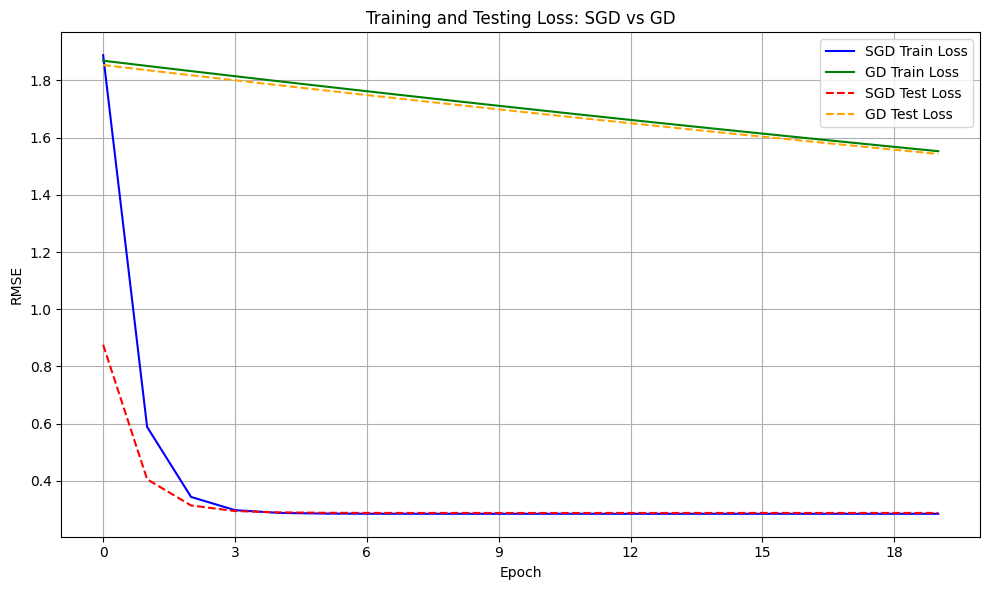

In [20]:
# 设置参数
num_epoch = 20
learning_rate = 0.01
batch_size = 32

np.random.seed(0)

# 运行 SGD
_, train_losses_sgd, test_losses_sgd = SGD(num_epoch, learning_rate, batch_size)

# 运行 GD（注意：GD函数不需要batch_size参数，可以忽略）
theta_gd, train_losses_gd, test_losses_gd = GD(num_epoch, learning_rate)

# 可视化：将 SGD 和 GD 的 loss 曲线画在一起进行对比
plt.figure(figsize=(10, 6))

# 训练损失曲线
plt.plot(np.arange(num_epoch), train_losses_sgd, color='blue', label='SGD Train Loss')
plt.plot(np.arange(num_epoch), train_losses_gd, color='green', label='GD Train Loss')

# 测试损失曲线
plt.plot(np.arange(num_epoch), test_losses_sgd, color='red', linestyle='--', label='SGD Test Loss')
plt.plot(np.arange(num_epoch), test_losses_gd, color='orange', linestyle='--', label='GD Test Loss')

# 设置 x 轴为整数刻度
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

# 标签与图例
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Training and Testing Loss: SGD vs GD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### 可以看出SGD的收敛速度明显更快

---

# 不同学习率对RMSE的影响和回归的效果

回归系数： [ 0.64793055  0.47076949  0.34198212 -0.00103996  0.42536317  0.00170501]
回归系数： [ 6.52878493e-01  4.67285808e-01  3.37472562e-01  5.79803035e-03
  4.28239516e-01 -3.91890814e-04]
回归系数： [ 0.45282878  0.49685917  0.49510686 -0.21996969  0.42216171 -0.09010888]


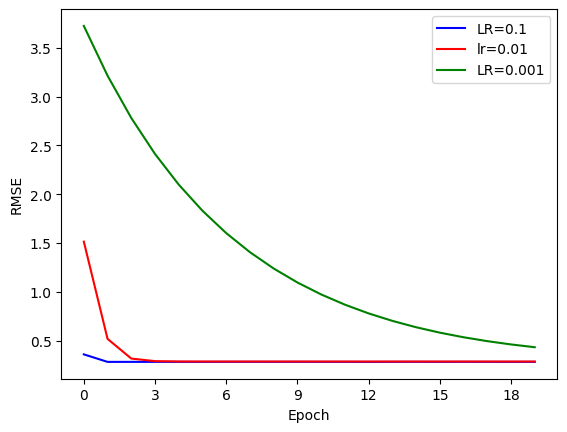

In [21]:
_, lose1, _=SGD(num_epoch=num_epoch,learning_rate=0.1,batch_size=batch_size)
_, lose2, _=SGD(num_epoch=num_epoch,learning_rate=0.01,batch_size=batch_size)
_, lose3, _=SGD(num_epoch=num_epoch,learning_rate=0.001,batch_size=batch_size)

plt.plot(np.arange(num_epoch),lose1,color='blue',label='LR=0.1')
plt.plot(np.arange(num_epoch), lose2, color='red', label='lr=0.01')
plt.plot(np.arange(num_epoch),lose3,color='green',label='LR=0.001')

plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.show()



可以看到，随着学习率的增大，算法的收敛效果明显加快

那么，学习率不是越大越好？我们将学习率继续上调到1.5，来看看结果

回归系数： [-7.36481349e+71  1.99869877e+71 -7.38233724e+71 -4.18850402e+71
  9.51745333e+71  1.04711554e+72]
最终损失： 3.826048767577616e+71


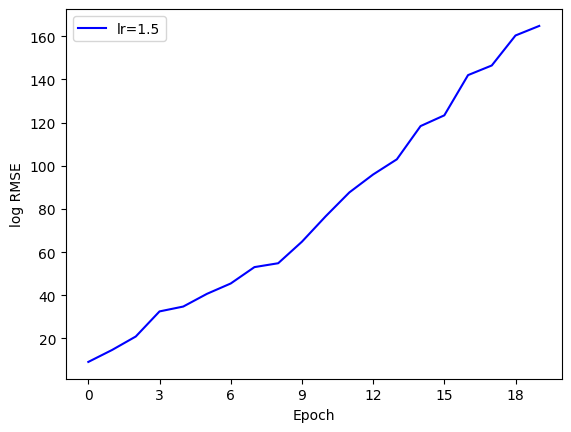

In [24]:
_, loss3, _ = SGD(num_epoch=num_epoch, learning_rate=1.5, batch_size=batch_size)
print('最终损失：', loss3[-1])
plt.plot(np.arange(num_epoch), np.log(loss3), color='blue', label='lr=1.5')
plt.xlabel('Epoch')
plt.ylabel('log RMSE')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.show()

我们可以看到，算法的RMSE在迭代过程中不但没有减小，反而发散了

所以选择一个合适的学习率是算法的重中之重